<a href="https://colab.research.google.com/github/1900690/kyouyu/blob/main/%E3%83%9E%E3%82%B9%E3%82%AF%E7%94%BB%E5%83%8F%E3%81%8B%E3%82%89COCO%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E4%BD%9C%E6%88%90.5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#背景処理画像を作成
[remobe.bg](https://www.remove.bg/ja)にアクセスして、背景消去した画像を作成する

※フォルダには生画像、背景処理画像をセットで入れておく

##グーグルドライブから画像を入手する場合

グーグルドライブをマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##ローカルから画像を入手する場合

画像の入ったフォルダをzip化(日本語は文字化けする)、ダウンロードののち、以下のコードで解凍

In [ ]:
!unzip -q haikeisyori.zip

ディレクトリを移動

In [ ]:
%cd haikeisyori

/content/haikeisyori


読み込んだ画像を表示する場合

・OpenCVを使って画像を読み込む cv2.imreadでOpenCV形式に変換 OpenCVはBGRなのでcvtColorでRGBに直してから表示する

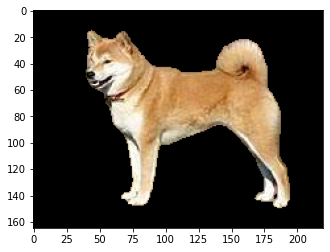

In [ ]:
import cv2
from matplotlib import pyplot as plt
orig = cv2.imread('/content/haikeisyori/inu-removebg-preview.png')
src = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
plt.imshow(src)

#画像の仕分け

画像のリストを取得し、生画像、背景処理画像それぞれのフォルダに入れる

In [ ]:
#参考https://kino-code.com/files-move/
import os
import shutil

file_extensions = ['jpg', 'png']
file_extensions 

#読み取りたいディレクトリパスを入れる
read_path = './copy_from'
read_files = os.listdir(read_path)

#拡張子リストを取得するフォー文を追加する。
for file_extension in file_extensions:
    os.mkdir('./' + file_extension)

    #指定の拡張子だけのファイル名をリストを作る
    file_list = []
    for file_name in read_files:
        if file_name.endswith(file_extension):
            file_list.append(file_name)

    #read_listから、指定の拡張子のファイルだけ指定のディレクトリにコピーする
    for file_name in file_list:
        copy_from = './' + read_path + '/' + file_name    
        copy_to = './' + file_extension + '/' + file_name 
        shutil.copy2(copy_from, copy_to)

NameError: ignored

アルファチャンネル（透過度）のみ取得

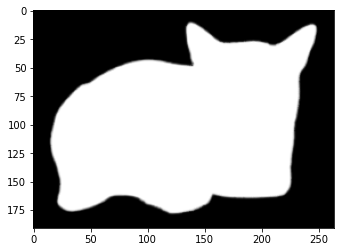

In [ ]:
import cv2

# 読み込みたい画像のファイルパス
IMAGE_PATH = "/content/neko-removebg-preview.png"

# アルファチャネルのみの画像を保存するファイルパス
SAVE_PATH = "/content/neko-removebg-preview2.png"

# 画像を読み込んでNumPy配列を作成
image = cv2.imread(IMAGE_PATH, cv2.IMREAD_UNCHANGED)

# スライスを利用してアルファチャンネルのみを切り出し
alpha_image = image[:,:,3]

# 画像ファイルとして保存
cv2.imwrite(SAVE_PATH, alpha_image)

#画像を表示
plt.imshow(alpha_image)

#白黒表示
plt.gray()

Imageフォルダとmaskフォルダを作成。Imageフォルダには元の画像を、maskフォルダにはマスク画像を入れる。それぞれのセットごとに同じ名前を付けること

In [ ]:
!mkdir "mask"
!mkdir "image"

ライブラリインポート

In [ ]:
import json
import collections as cl
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from skimage import measure
from skimage.segmentation import clear_border
from skimage.filters import threshold_otsu
import cv2
import glob
import sys
import os

関数定義

In [ ]:
### https://qiita.com/harmegiddo/items/da131ae5bcddbbbde41f

def info():
    tmp = cl.OrderedDict()
    tmp["description"] = "Test"
    tmp["url"] = "https://test"
    tmp["version"] = "0.01"
    tmp["year"] = 2020
    tmp["contributor"] = "salt22g"
    tmp["data_created"] = "2020/12/20"
    return tmp

def licenses():
    tmp = cl.OrderedDict()
    tmp["id"] = 1
    tmp["url"] = "dummy_words"
    tmp["name"] = "salt22g"
    return tmp

def images(mask_path):
    tmps = []
    files = glob.glob(mask_path + "/*.png")
    files.sort()

    for i, file in enumerate(files):
        img = cv2.imread(file, 0)
        height, width = img.shape[:3]

        tmp = cl.OrderedDict()
        tmp["license"] = 1
        tmp["id"] = i
        tmp["file_name"] = os.path.basename(file)
        tmp["width"] = width
        tmp["height"] = height
        tmp["date_captured"] = ""
        tmp["coco_url"] = "dummy_words"
        tmp["flickr_url"] = "dummy_words"
        tmps.append(tmp)
    return tmps


def annotations(mask_path):
    tmps = []

    files = glob.glob(mask_path + "/*.png")
    files.sort()
    
    for i, file in enumerate(files):
        img = cv2.imread(file, 0)
        tmp = cl.OrderedDict()
        contours = measure.find_contours(img, 0.5)
        segmentation_list = []

        for contour in contours:
            for a in contour:
                segmentation_list.append(a[0])
                segmentation_list.append(a[1])


        mask = np.array(img)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]
        masks = mask == obj_ids[:, None, None]
        num_objs = len(obj_ids)
        boxes = []

        for j in range(num_objs):
            pos = np.where(masks[j])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        tmp_segmentation = cl.OrderedDict()

        tmp["segmentation"] = [segmentation_list]
        tmp["id"] = str(i)
        tmp["image_id"] = i
        tmp["category_id"] = 1
        tmp["area"] = float(boxes[0][3] - boxes[0][1]) * float(boxes[0][2] - boxes[0][0])
        tmp["iscrowd"] = 0
        tmp["bbox"] =  [float(boxes[0][0]), float(boxes[0][1]), float(boxes[0][3] - boxes[0][1]), float(boxes[0][2] - boxes[0][0])]
        tmps.append(tmp)
    return tmps

def categories():
    tmps = []
    sup = ["person"]
    cat = ["person"]
    for i in range(len(sup)):
        tmp = cl.OrderedDict()
        tmp["id"] = i+1
        tmp["name"] = cat[i]
        tmp["supercategory"] = sup[i]
        tmps.append(tmp)
    return tmps

def main(mask_path, json_name):
    query_list = ["info", "licenses", "images", "annotations", "categories", "segment_info"]
    js = cl.OrderedDict()
    for i in range(len(query_list)):
        tmp = ""
        # Info
        if query_list[i] == "info":
            tmp = info()

        # licenses
        elif query_list[i] == "licenses":
            tmp = licenses()

        elif query_list[i] == "images":
            tmp = images(mask_path)

        elif query_list[i] == "annotations":
            tmp = annotations(mask_path)

        elif query_list[i] == "categories":
            tmp = categories()

        # save it
        js[query_list[i]] = tmp

    # write
    fw = open(json_name,'w')
    json.dump(js,fw,indent=2)

main

In [ ]:
#args = sys.argv
#mask_path = args[1]
mask_path =  "/content/mask"
#json_name = args[2]
json_name = "person_sample.json"

if __name__=='__main__':
    main(mask_path, json_name)